# Causal Probabilistic Programming

Date: 2025-10-09
Author: Matt McDonnell

Watched Sam Witty's interview with the [Learning Bayes podcast](https://learnbayesstats.com/episode/141-ai-assisted-causal-inference-sam-witty) yesterday.  It was very thought-provoking: going from probabilistic
programming in [Pyro]() to causal probabilistic programming in [ChiRho](https://basisresearch.github.io/chirho/index.html).  The route is by using interventions to transform
structural causal models.  This feels like a category and there is a talk by Taco Cohen in ai4cats that looks relevant.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from chirho.interventional.handlers import do


# Getting Started
Example from [getting started](https://basisresearch.github.io/chirho/getting_started.html) section of ChiRho doc.

In [1]:
# https://basisresearch.github.io/chirho/getting_started.html
pyro.set_rng_seed(101)

# Define a causal model with single confounder h
def model():
    h = pyro.sample("h", dist.Normal(0, 1))
    x = pyro.sample("x", dist.Normal(h, 1))
    y = pyro.sample("y", dist.Normal(x + h, 1))
    return y

# Define a causal query (here intervening on x)
def queried_model():
    return do(model, {"x": 1})

# Generate 10,000 samples from the observational distribution P(y) ~ N(0, 2)
obs_samples = pyro.infer.Predictive(model, num_samples=1000)()["y"]

# Generate 10,000 samples from the interventional distribution P(y | do(X=1)) ~ N(1, 1)
int_samples = pyro.infer.Predictive(queried_model(), num_samples=1000)()["y"]

/Users/mattmcd/Work/Projects/PyBayes/.venv/lib/python3.12/site-packages/pyro/ops/stats.py:527: SyntaxWarning: invalid escape sequence '\g'
  we have :math:`ES^{*}(P,Q) \ge ES^{*}(Q,Q)` with equality holding if and only if :math:`P=Q`, i.e.


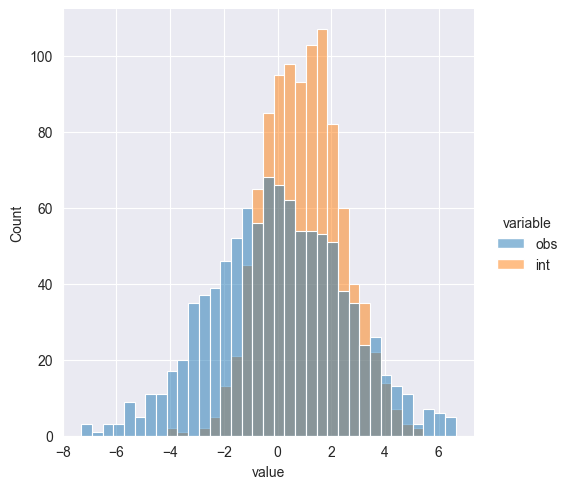

In [4]:
df_plot = pd.DataFrame({'obs': obs_samples, 'int': int_samples}).melt()
_ = sns.displot(df_plot, hue='variable', x='value')

# Causal Probabilistic Programming Without Tears
Example from [tutorial](https://basisresearch.github.io/chirho/tutorial_i.html) section of ChiRho doc.

In [6]:
from pyro.distributions import Bernoulli, Beta
from pyro.infer import SVI
from pyro.infer.autoguide import AutoNormal
from pyro.ops.indexing import Vindex
from pyro.poutine import block

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


In [7]:
import pyro.distributions as pyd

In [9]:
def causal_model(stress_prob, smokes_cond_prob, cancer_cond_prob):
    stress = pyro.sample("stress", Bernoulli(stress_prob))

    # Vindex is a helper function that allows for broadcastable indexing into a tensor
    smokes_prob = Vindex(smokes_cond_prob)[..., stress.int()]
    smokes = pyro.sample("smokes", Bernoulli(smokes_prob))

    cancer_prob = Vindex(cancer_cond_prob)[..., stress.int(), smokes.int()]
    cancer = pyro.sample("cancer", Bernoulli(cancer_prob))

    return {"stress": stress, "smokes": smokes, "cancer": cancer}

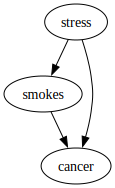

In [10]:
stress_prob = torch.tensor(0.5) # 50% chance of stress
smokes_cond_prob = torch.tensor([0.2, 0.8]) # 20% chance of smoking if not stressed, 80% if stressed
cancer_cond_prob = torch.tensor([[0.1, 0.15], [0.8, 0.85]]) # If not stressed 10% chance of cancer if not smoking, 15% if smoking

pyro.render_model(causal_model, (stress_prob, smokes_cond_prob, cancer_cond_prob))

In [19]:
n_individuals = 10000

def population_causal_model(n_individuals, stress_prob, smokes_cond_prob, cancer_cond_prob):
    with pyro.plate("individuals", n_individuals, dim=-1):
        return causal_model(stress_prob, smokes_cond_prob, cancer_cond_prob)

result = population_causal_model(n_individuals, stress_prob, smokes_cond_prob, cancer_cond_prob)

print("smokes.shape ---", result["smokes"].shape)

smokes.shape --- torch.Size([10000])


In [23]:
num_samples = 5000

def visualize_proportions_single(prediction, title):
    cancer = prediction["cancer"]
    smokes = torch.broadcast_tensors(prediction["smokes"], prediction["cancer"])[0]

    assert cancer.shape == smokes.shape

    data = torch.concat((smokes.reshape(-1, 1), cancer.reshape(-1, 1)), axis=-1)
    frame = pd.DataFrame(data.numpy(), columns=["smokes", "cancer"])# .astype("category").replace({0: "0", 1: "1"})
    return frame
    df_pivot = pd.pivot_table(frame, aggfunc='sum')
    return sns.histplot(x="smokes", hue="cancer", multiple="dodge", shrink=0.7, data=frame).set(title=title)


prediction_fixed = population_causal_model(n_individuals, stress_prob, smokes_cond_prob, cancer_cond_prob)

df_pf = visualize_proportions_single(prediction_fixed, "Observational Data - Fixed Parameters")

In [36]:
df_pf.astype('category').apply(
    lambda x: x.cat.rename_categories({0: '0', 1: '1'})
).assign(C=1).groupby(['smokes', 'cancer'])['C'].sum().unstack()

/var/folders/b8/svt9dx110s13hpxdqm0n3hl00000gn/T/ipykernel_46248/3425920789.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ).assign(C=1).groupby(['smokes', 'cancer'])['C'].sum().unstack()


cancer,0,1
smokes,,
0,3819,1272
1,1421,3488
